In [8]:
import sys
import os
import glob
import pandas as pd
import gensim.downloader as api
import numpy as np
import importlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import caption_to_embedding
from load_hdf5 import load_depth_maps_from_hdf5
from caption_to_embedding import transform_captions

print(sys.path)
input_map = "/tank/tgn252/metadata_annotations/result"
video_names = os.listdir(input_map)
print(len(video_names))


['/tank/tgn252/metadata_annotations/scripts', '/tank/tgn252/anaconda3/envs/metadata_stats/lib/python39.zip', '/tank/tgn252/anaconda3/envs/metadata_stats/lib/python3.9', '/tank/tgn252/anaconda3/envs/metadata_stats/lib/python3.9/lib-dynload', '', '/tank/tgn252/.local/lib/python3.9/site-packages', '/tank/tgn252/anaconda3/envs/metadata_stats/lib/python3.9/site-packages', '/tank/tgn252/metadata_annotations/src']
1138


In [6]:
def get_dirs_with_subdir(dirs, subdir_name):
    """
    Returns a dictionary where the keys are directory names and the values are True if the directory contains a subdirectory with the given name, and False otherwise.

    Args:
        dirs (list): List of directory paths.
        subdir_name (str): Name of the subdirectory to check for.

    Returns:
        dict: Dictionary where the keys are directory names and the values are True if the directory contains a subdirectory with the given name, and False otherwise.
    """
    dirs_with_subdir = {}
    for d in dirs:
        subdirs = os.listdir(d)
        dirs_with_subdir[d] = subdir_name in subdirs
    return dirs_with_subdir

In [9]:
full_paths = [os.path.join(input_map, video_name) for video_name in video_names]
maps = get_dirs_with_subdir(full_paths, 'depth_estimation')
true_dirs = [keys for keys, values in maps.items() if values]
false_dirs = [keys for keys, values in maps.items() if not values]
print(f'n of maps with searched subdirectories : {len(true_dirs)}' )
print(f'n of total maps: {len(maps.keys())} ')

n of maps with searched subdirectories : 971
n of total maps: 1138 


In [8]:
import os

# Create a list to store the paths
empty_subsubfolders = []

# Iterate over each directory in dirs
for dir in true_dirs:
    # Get a list of subfolders
    subfolders = [name for name in os.listdir(dir) if os.path.isdir(os.path.join(dir, name))]
    # Iterate over each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(dir, subfolder)
        # Get a list of subsubfolders
        subsubfolders = [name for name in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, name))]
        # If there is exactly one subsubfolder
        if len(subsubfolders) == 1:
            subsubfolder_path = os.path.join(subfolder_path, subsubfolders[0])
            # Get a list of files in the subsubfolder
            files = [name for name in os.listdir(subsubfolder_path) if os.path.isfile(os.path.join(subsubfolder_path, name))]
            # If the subsubfolder contains no files, add it to the list
            if len(files) == 0:
                empty_subsubfolders.append(subsubfolder_path)

print(empty_subsubfolders)

[]


In [ ]:
import os
import shutil

# Iterate over each directory in dirs
for dir in full_paths:
    # Get a list of subfolders
    subfolders = [name for name in os.listdir(dir) if os.path.isdir(os.path.join(dir, name))]
    # Iterate over each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(dir, subfolder)
        # Get a list of subsubfolders
        subsubfolders = [name for name in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, name))]
        # If there is exactly one subsubfolder
        if len(subsubfolders) == 1:
            subsubfolder_path = os.path.join(subfolder_path, subsubfolders[0])
            # Get a list of files in the subsubfolder
            files = [name for name in os.listdir(subsubfolder_path) if os.path.isfile(os.path.join(subsubfolder_path, name))]
            # If the subsubfolder contains no files, delete the 'keypoints' subfolder
            if len(files) == 0:
                shutil.rmtree(subfolder_path)

In [10]:
def find_files(video_name, dir_name, file_type, base_path="/tank/tgn252/metadata_annotations/result"):
    """
    Find all files of a given type in a specified directory (and its subdirectories) for a given video.

    Args:
        video_name (str): The name of the video.
        dir_name (str): The name of the directory to search.
        file_type (str): The type of the files to find (e.g., "csv" or "hdf5").
        base_path (str): The base path where the video directories are located.

    Returns:
        files (list): A list of paths to the files.
    """
    search_path = os.path.join(base_path, video_name, dir_name)
    files = glob.glob(os.path.join(search_path, f"**/*.{file_type}"), recursive=True)
    return files

In [12]:
data = {}
video_names = true_dirs[:100]
for video_name in video_names:
    print(f"Processing video {video_name}")
    video_data = {}
    # Load depth map from HDF5 file
    hdf5_files = find_files(video_name, 'depth_estimation', 'h5')
    if hdf5_files:
        depth_map = load_depth_maps_from_hdf5(hdf5_files[0])
        video_data["depth_map"] = depth_map
    else:
        print(f"No HDF5 file found for video {video_name}")
        continue  # Skip to the next video if no depth map is found

    # Find CSV file in "captioning" subdirectory
    caption_csv = find_files(video_name, 'captioning', 'csv')
    if caption_csv:
        captions_df = pd.read_csv(caption_csv[0]) 
        # Extract the first caption
        caption = captions_df["Caption"].iloc[0]
        video_data["caption"] = caption
    else:
        print(f"No CSV file found in captioning directory for video {video_name}")
        continue  # Skip to the next video if no caption is found

    # Only add the video to the dictionary if it has both a depth map and a caption
    data[video_name] = video_data

print(len(data.keys()))

Processing video /tank/tgn252/metadata_annotations/result/R_S_yt--jzScB82vKI_212.mp4
Processing video /tank/tgn252/metadata_annotations/result/R_S_wc-hmW1OnCPF_xn_37.mp4
Processing video /tank/tgn252/metadata_annotations/result/R_S_yt-r5kRl-2lVxc_2.mp4
Processing video /tank/tgn252/metadata_annotations/result/S_yt-3V8US8ZD3NU_229.mp4
Processing video /tank/tgn252/metadata_annotations/result/S_yt-tMP5WhHMtWE_55.mp4
Processing video /tank/tgn252/metadata_annotations/result/R_S_yt-y3tyx6cZjmA_412.mp4
Processing video /tank/tgn252/metadata_annotations/result/S_production_ID_5102663.mp4
Processing video /tank/tgn252/metadata_annotations/result/S_yt-oPeZEUtqKNM_27.mp4
Processing video /tank/tgn252/metadata_annotations/result/R_S_yt-STL3ejY9u_Q_73.mp4
Processing video /tank/tgn252/metadata_annotations/result/R_S_wc-3IayTPy_A3nF_17.mp4
Processing video /tank/tgn252/metadata_annotations/result/R_S_3dzza09VbXY_235.mp4
Processing video /tank/tgn252/metadata_annotations/result/S_ILSVRC2015_train_0

In [13]:
model = api.load("glove-wiki-gigaword-100")
embedding_vector_size = 100
for video_name, values in data.items():
    caption = values["caption"]
    embeddings = transform_captions(caption, model)
    if len(embeddings) != embedding_vector_size:
        print(f"Embeddings for video {video_name} has length {len(embeddings)}, should match {model} length of 100")
    data[video_name]["embeddings"] = embeddings

In [13]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Assuming 'data' is a dictionary with video names as keys and their metadata as values
for video_name, values in data.items():
    caption = values["caption"]
    
    # Generate the embedding for the entire sentence
    embedding = model.encode(caption)
    
    # Store the embedding back in the data dictionary
    data[video_name]["embeddings"] = embedding

/tank/tgn252/anaconda3/envs/metadata_stats/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config.json: 100%|██████████| 612/612 [00:00<00:00, 86.1kB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:00<00:00, 111MB/s] 
/tank/tgn252/anaconda3/envs/metadata_stats/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
tokenizer_config.json: 100%|██████████| 350/350 [00:00<00:00, 48.7kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.39MB/s]
tokenizer.json: 100%|██████████| 

We give multiple ccas, lets first do single value for a video

In [14]:
for video_name, values in data.items():
    depth_map = values["depth_map"]

    # Compute the mean and standard deviation over all pixels
    depth_map_frame = np.mean(depth_map, axis=(2, 3)) # gives 1 value per frame
    depth_map_video = np.mean(depth_map_frame, axis=0) # gives 1 value per video
    data[video_name]["depth_map__single_video"] = depth_map_video

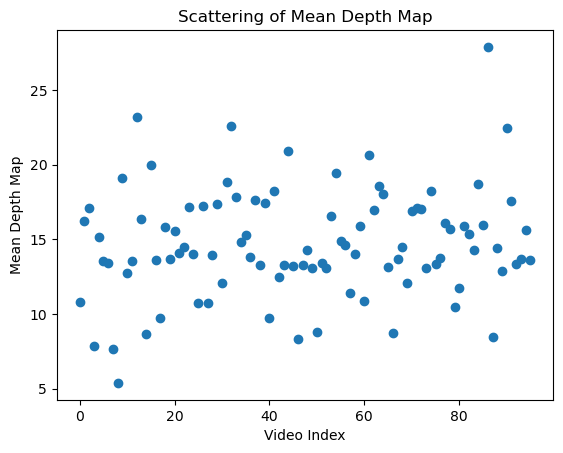

In [20]:
# Create a list to store the mean depth map values
mean_depth_map_values = []

# Iterate over the data dictionary and extract the mean depth map values
for values in data.values():
    mean_depth_map_values.append(values["depth_map__single_video"])

# Convert the list to a NumPy array
mean_depth_map_values = np.array(mean_depth_map_values)

# Scatter plot of the mean depth map values
plt.scatter(range(len(mean_depth_map_values)), mean_depth_map_values)
plt.xlabel('Video Index')
plt.ylabel('Mean Depth Map')
plt.title('Scattering of Mean Depth Map')
plt.show()

In [16]:
# Create a list for each set of variables
embeddings = []
depth_maps = []
shape = None
for video_name, values in data.items():
    if shape is None:
        shape = values["depth_map__single_video"].shape
    if values["depth_map__single_video"].shape == shape:
        depth_maps.append(values["depth_map__single_video"])
        embeddings.append(values["embeddings"])

# Convert the lists to NumPy arrays
embeddings = np.array(embeddings)
depth_maps = np.array(depth_maps)
print(embeddings.shape)
print(depth_maps.shape)

(971, 100)
(971, 1)


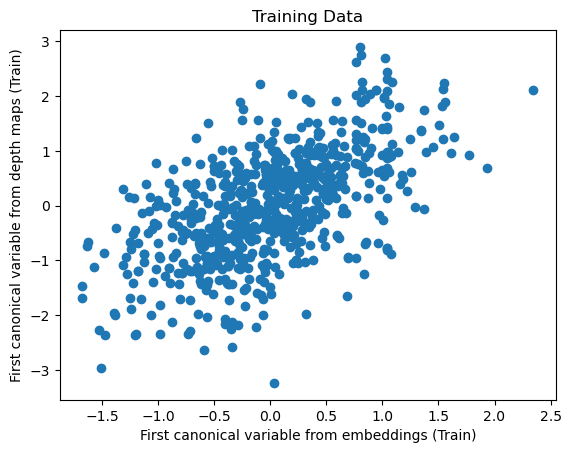

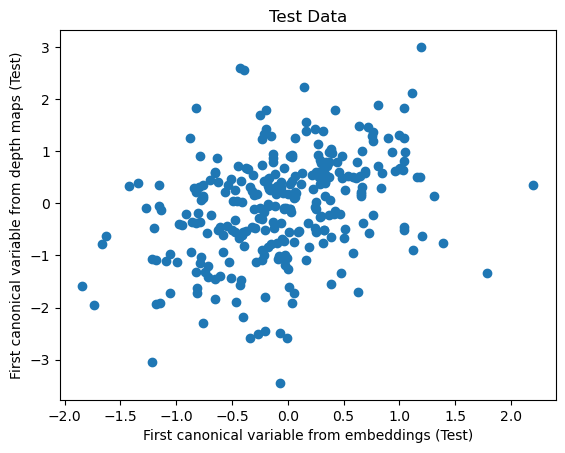

Training set canonical correlation: 0.34395666175481254
Test set canonical correlation: 0.049861107330068766


In [17]:

# Split your data into a training set and a test set
embeddings_train, embeddings_test, depth_maps_train, depth_maps_test = train_test_split(
    embeddings, depth_maps, test_size=0.3, random_state=42)

# Create a CCA object
cca = CCA(n_components=1)

# Fit the CCA model to your training data
cca.fit(embeddings_train, depth_maps_train)

# Apply the CCA transformation to your training data and test data
embeddings_train_c, depth_maps_train_c = cca.transform(embeddings_train, depth_maps_train)
embeddings_test_c, depth_maps_test_c = cca.transform(embeddings_test, depth_maps_test)
# Plot the first canonical variable from the transformed training data
plt.scatter(embeddings_train_c[:, 0], depth_maps_train_c[:, 0])
plt.xlabel('First canonical variable from embeddings (Train)')
plt.ylabel('First canonical variable from depth maps (Train)')
plt.title('Training Data')
plt.show()

# Plot the first canonical variable from the transformed test data
plt.scatter(embeddings_test_c[:, 0], depth_maps_test_c[:, 0])
plt.xlabel('First canonical variable from embeddings (Test)')
plt.ylabel('First canonical variable from depth maps (Test)')
plt.title('Test Data')
plt.show()
# Compute the canonical correlation for the training set
train_correlation = cca.score(embeddings_train, depth_maps_train)
print(f'Training set canonical correlation: {train_correlation}')

# Compute the canonical correlation for the test set
test_correlation = cca.score(embeddings_test, depth_maps_test)
print(f'Test set canonical correlation: {test_correlation}')

Let standardize this time:

/tank/tgn252/anaconda3/envs/metadata_stats/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


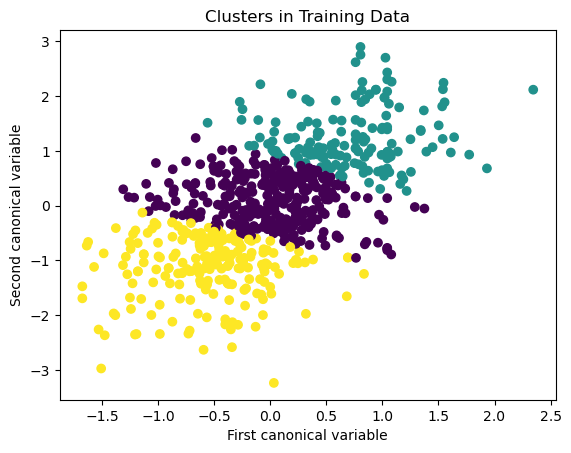

In [18]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming you want to cluster the combined canonical variables from both embeddings and depth maps
# Concatenate the canonical variables for clustering
combined_train_c = np.concatenate((embeddings_train_c, depth_maps_train_c), axis=1)

# Choose the number of clusters
# This is an arbitrary choice for demonstration; you may want to use methods like the elbow method to choose an optimal number
n_clusters = 3

# Initialize the KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the KMeans model to the combined canonical variables
kmeans.fit(combined_train_c)

# Predict the cluster labels for the training data
cluster_labels_train = kmeans.labels_

# Optionally, you can also predict the cluster labels for the test data if you have combined it similarly
combined_test_c = np.concatenate((embeddings_test_c, depth_maps_test_c), axis=1)
cluster_labels_test = kmeans.predict(combined_test_c)

# Plot the clusters for visualization (optional, for 2D data)
import matplotlib.pyplot as plt

# For visualization purposes, this example assumes you can plot the first two canonical variables. Adjust accordingly.
plt.scatter(combined_train_c[:, 0], combined_train_c[:, 1], c=cluster_labels_train, cmap='viridis')
plt.xlabel('First canonical variable')
plt.ylabel('Second canonical variable')
plt.title('Clusters in Training Data')
plt.show()

# Analyze the clusters
# Here, you might explore the characteristics of each cluster, for example, by examining the videos associated with each cluster label.



In [19]:
import numpy as np

# Assuming 'cluster_labels_train' contains the cluster labels for the training data
# and 'embeddings_train', 'depth_maps_train' are your original training datasets

# Number of clusters used
n_clusters = 3

# Initialize lists to store centroids of embeddings and average depth values for each cluster
centroids_embeddings = []
average_depths = []

for cluster_id in range(n_clusters):
    # Indices of items in this cluster
    indices = np.where(cluster_labels_train == cluster_id)[0]
    
    # Calculate centroid of embeddings for this cluster
    centroid_embedding = np.mean(embeddings_train[indices], axis=0)
    centroids_embeddings.append(centroid_embedding)
    
    # Calculate average depth value for this cluster
    average_depth = np.mean(depth_maps_train[indices], axis=0)
    average_depths.append(average_depth)

# centroids_embeddings now contains the centroid of embeddings for each cluster
# average_depths contains the average depth values for each cluster

# Optional: To inspect the centroids and averages for each cluster
for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id+1}:")
    print(f"  Embedding Centroid: {centroids_embeddings[cluster_id]}")
    print(f"  Average Depth: {average_depths[cluster_id]}")
    print("\n")


Cluster 1:
  Embedding Centroid: [-0.11408304  0.19169496  0.25175681 -0.22091462  0.23531717  0.43975663
 -0.01046002  0.3301792  -0.20727806  0.11017209 -0.10796195 -0.0474503
  0.27897858  0.12422171  0.18788556 -0.06674691  0.279882   -0.07100439
 -0.1301542   0.02406811  0.29583866  0.07948972  0.23884228 -0.03624332
  0.41435294  0.03366663 -0.32719024 -0.42893051 -0.06942143  0.03486418
 -0.21280632  0.45096594  0.06137017  0.0174429   0.16708867  0.1686553
 -0.12200249  0.27730011  0.30823767  0.00887426 -0.27916255 -0.20800038
  0.32703149 -0.31113098  0.06337814  0.10458489  0.15633248 -0.05028975
 -0.14694314 -0.59699559 -0.10320658 -0.21617847  0.19570746  1.13006169
 -0.34324382 -2.53086167 -0.1387599  -0.14295805  1.57456112  0.43461921
 -0.02800712  0.73704458 -0.22255684  0.18139354  0.66239479  0.09229992
  0.52146058  0.22564881  0.08165842 -0.05144373 -0.16095545 -0.17741837
 -0.05965398 -0.16252239  0.19876206  0.11542227 -0.04025375 -0.10605374
 -0.72575027  0.0029

In [50]:
scaler = StandardScaler()

In [58]:


# First, compute the average depth map for each video
depth_map_videos = []
for video_name, values in data.items():
    depth_map = values["depth_map"]
    depth_map_frame = np.mean(depth_map, axis=(2, 3)) # gives 1 value per frame
    depth_map_video = np.mean(depth_map_frame, axis=0) # gives 1 value per video
   
    depth_map_videos.append(depth_map_video)

# Convert the list to a numpy array and reshape it to fit the scaler's expected input shape
depth_map_videos = np.array(depth_map_videos).reshape(-1, 1)

# Create a scaler and fit it to the depth map videos
scaler = StandardScaler()
scaler.fit(depth_map_videos)

# Now, standardize the average depth map for each video
for video_name, values in data.items():
    depth_map = values["depth_map"]
    depth_map_frame = np.mean(depth_map, axis=(2, 3)) # gives 1 value per frame
    depth_map_video = np.mean(depth_map_frame, axis=0) # gives 1 value per video
    # Standardize the depth_map_video
    depth_map_video_standardized = scaler.transform(depth_map_video.reshape(-1, 1))[0]

    data[video_name]["depth_map_std_single_video"] = depth_map_video_standardized

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for video_name, values in data.items():
    embeddings = values["embeddings"]

    # Reshape the embeddings to fit the scaler's expected input shape
    embeddings = embeddings.reshape(-1, 1)

    # Standardize the embeddings
    embeddings_standardized = scaler.fit_transform(embeddings)
    embeddings_standardized = embeddings_standardized.flatten()

    data[video_name]["embeddings_standardized"] = embeddings_standardized

In [65]:
# Create a list for each set of variables
embeddings_std = []
depth_maps_std = []
shape = None
for video_name, values in data.items():
    if shape is None:
        shape = values["depth_map_std_single_video"].shape
    if values["depth_map_std_single_video"].shape == shape:
        depth_maps_std.append(values["depth_map_std_single_video"])
        embeddings_std.append(values["embeddings_standardized"])

# Convert the lists to NumPy arrays
embeddings_std = np.array(embeddings_std)
depth_maps_std = np.array(depth_maps_std)
print(embeddings_std.shape)
print(depth_maps_std.shape)

(115, 100)
(115, 1)


In [54]:
print(depth_maps_std[:5])

[[ 0.6465949 ]
 [-1.0498888 ]
 [ 0.37716264]
 [ 0.60749227]
 [ 2.177993  ]]


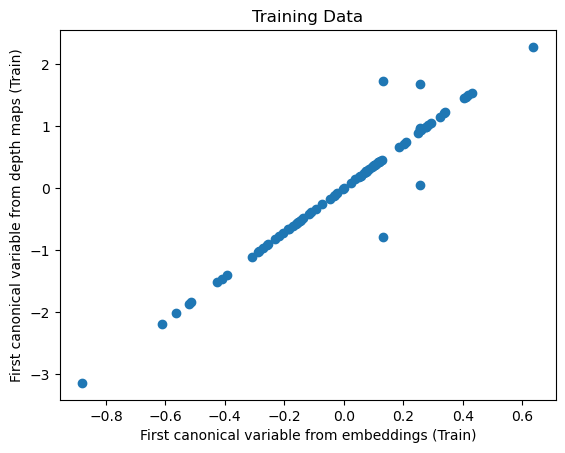

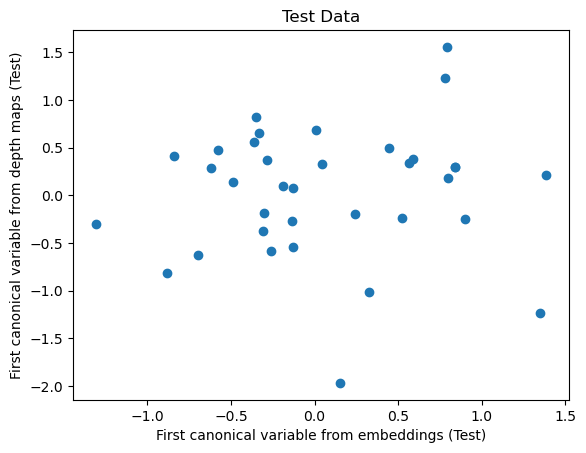

Training set canonical correlation: 0.4545676774075783
Test set canonical correlation: -0.7463840741241952


In [61]:
# Split your data into a training set and a test set
embeddings_train, embeddings_test, depth_maps_train, depth_maps_test = train_test_split(
    embeddings_std, depth_maps_std, test_size=0.3, random_state=60)

# Create a CCA object
cca = CCA(n_components=1)

# Fit the CCA model to your training data
cca.fit(embeddings_train, depth_maps_train)

# Apply the CCA transformation to your training data and test data
embeddings_train_c, depth_maps_train_c = cca.transform(embeddings_train, depth_maps_train)
embeddings_test_c, depth_maps_test_c = cca.transform(embeddings_test, depth_maps_test)

# Plot the first canonical variable from the transformed training data
plt.scatter(embeddings_train_c[:, 0], depth_maps_train_c[:, 0])
plt.xlabel('First canonical variable from embeddings (Train)')
plt.ylabel('First canonical variable from depth maps (Train)')
plt.title('Training Data')
plt.show()

# Plot the first canonical variable from the transformed test data
plt.scatter(embeddings_test_c[:, 0], depth_maps_test_c[:, 0])
plt.xlabel('First canonical variable from embeddings (Test)')
plt.ylabel('First canonical variable from depth maps (Test)')
plt.title('Test Data')
plt.show()

# Compute the canonical correlation for the training set
train_correlation = cca.score(embeddings_train, depth_maps_train)
print(f'Training set canonical correlation: {train_correlation}')

# Compute the canonical correlation for the test set
test_correlation = cca.score(embeddings_test, depth_maps_test)
print(f'Test set canonical correlation: {test_correlation}')

-0.07308979133012447


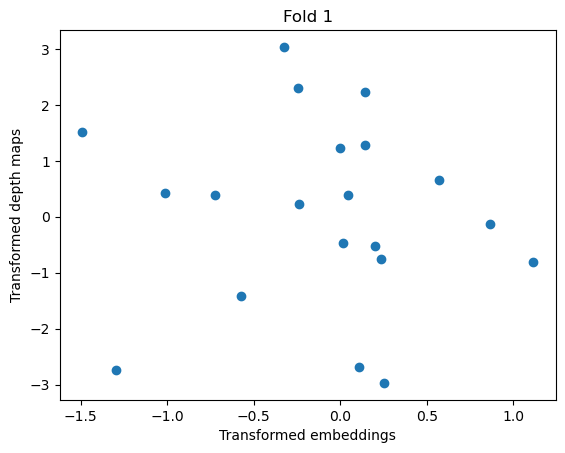

-0.17981128819317677


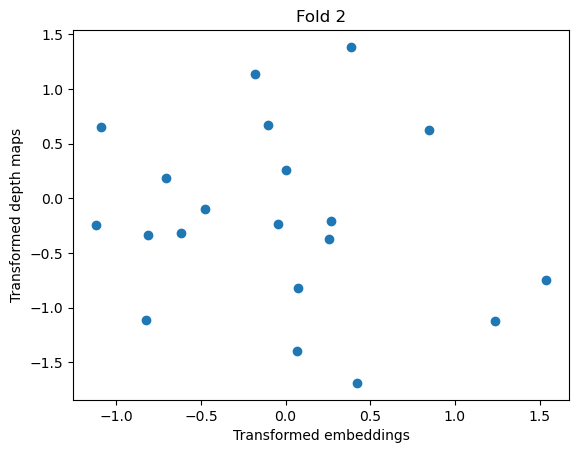

0.17089831775212586


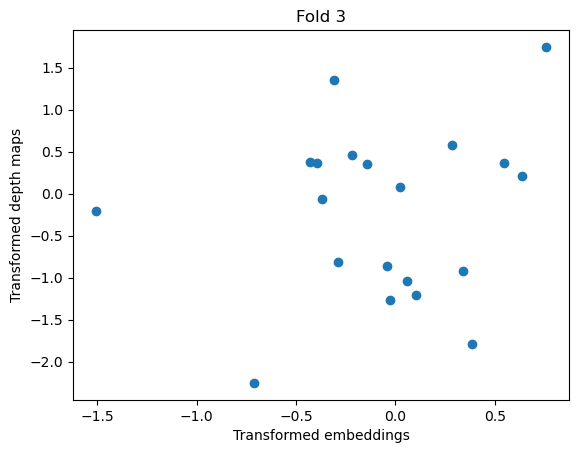

0.3430521699692438


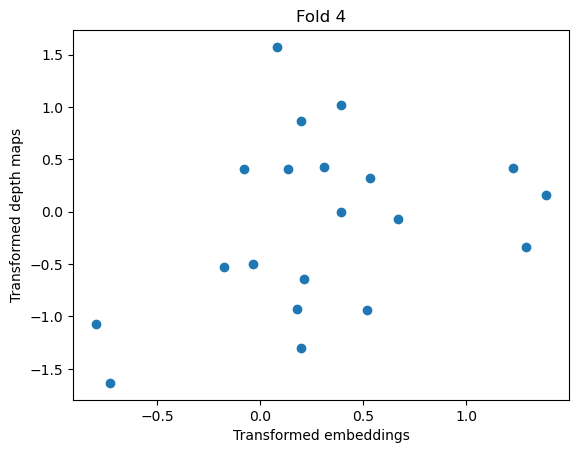

0.012449535085587733


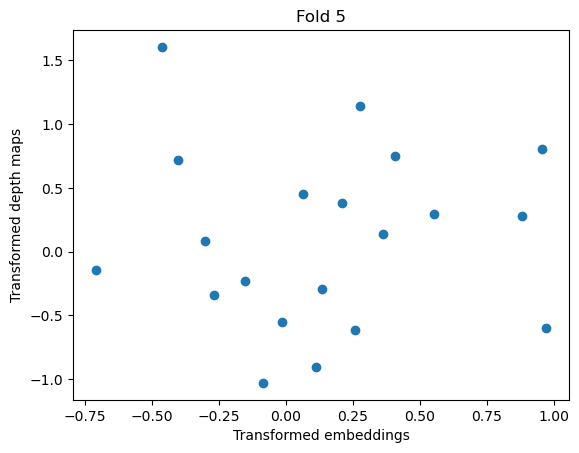

average correlation over folds is 0.05469978865673123


In [57]:
n_splits = 5  # For k-fold
kf = KFold(n_splits=n_splits)

canonical_correlations = []

for i, (train_index, test_index) in enumerate(kf.split(embeddings_std)):
    # Split data into training and test sets
    X_train, X_test = embeddings_std[train_index], embeddings_std[test_index]
    Y_train, Y_test = depth_maps_std[train_index], depth_maps_std[test_index]

    # Initialize and fit CCA
    cca3 = CCA(n_components=1)  # Choose appropriate number of components
    cca3.fit(X_train, Y_train)

    # Transform both training and test sets
    X_train_c, Y_train_c = cca3.transform(X_train, Y_train)
    X_test_c, Y_test_c = cca3.transform(X_test, Y_test)

    # Calculate and store the canonical correlation for the test set
    test_correlation = np.corrcoef(X_test_c[:, 0], Y_test_c[:, 0])[0, 1]
    canonical_correlations.append(test_correlation)
    print(test_correlation)
    # Plot the transformed test set
    plt.figure(i)
    plt.scatter(X_test_c[:, 0], Y_test_c[:, 0])
    plt.title(f'Fold {i+1}')
    plt.xlabel('Transformed embeddings')
    plt.ylabel('Transformed depth maps')
    plt.show()

# Average canonical correlation across all folds
average_canonical_correlation = np.mean(canonical_correlations)
print(f'average correlation over folds is {average_canonical_correlation}')

Lets try doing it with value per frame averaged over pixels not single value per video

In [73]:
for i, values in enumerate(data.values()):
    depth_map = values["depth_map"]
    # Compute the mean over the height and width dimensions, resulting in a tensor of shape (Frames, greyscale-value)
    mean_depth_map_per_frame = np.mean(depth_map, axis=(2, 3))
    #
    # Add the mean depth map per frame to the data dictionary
    values["mean_depth_map_per_frame"] = mean_depth_map_per_frame

In [74]:
mean_depth_map_per_frames = []
embeddings_frame = []
for values in data.values():
    mean_depth_map_per_frame = values["mean_depth_map_per_frame"]
    
    # Ensure that mean_depth_map_per_frame is a 1D array of length 150
    mean_depth_map_per_frame = mean_depth_map_per_frame.flatten()[:150]
    
    mean_depth_map_per_frames.append(mean_depth_map_per_frame)
    embeddings_frame.append(values["embeddings"])
mean_depth_map_per_frames = np.array(mean_depth_map_per_frames)
embeddings_frame = np.array(embeddings_frame)
print(mean_depth_map_per_frames.shape)
print(embeddings_frame.shape)

(135, 150)
(135, 100)


0.3439209233185184


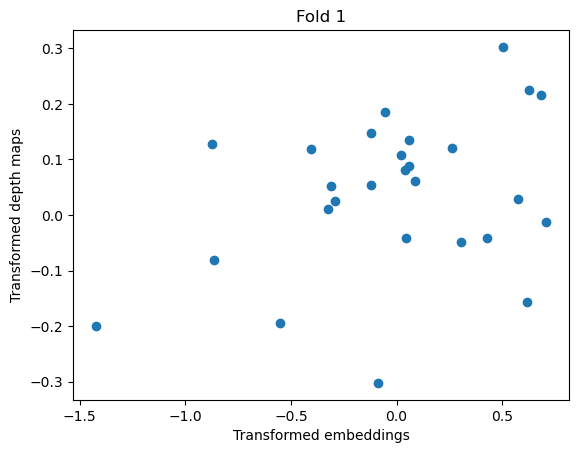

0.17534609002995022


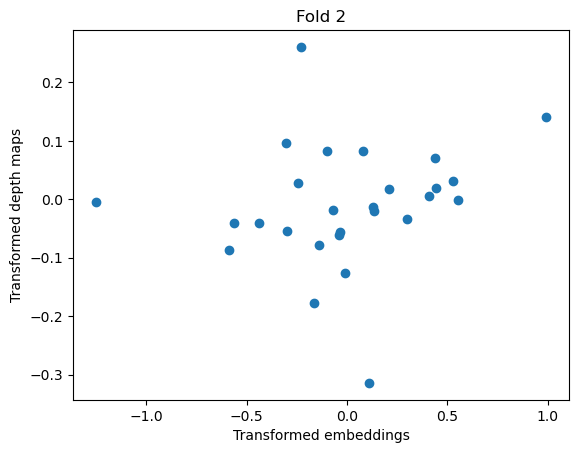

0.09363605924340387


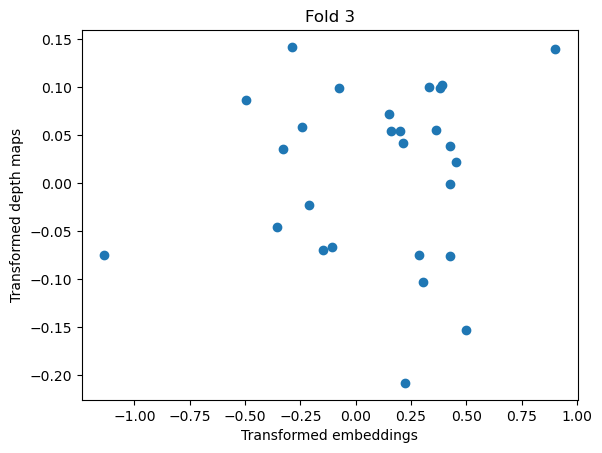

0.1228206844307648


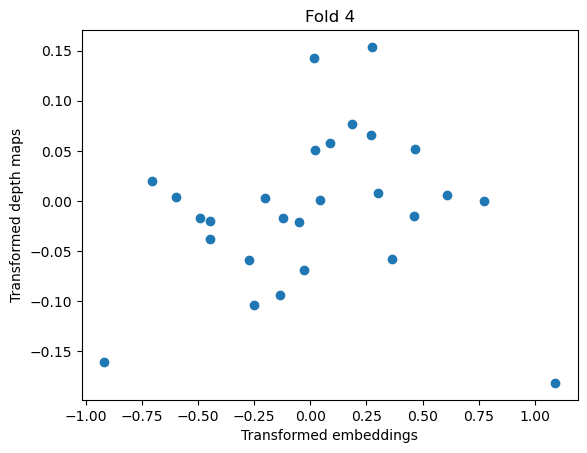

0.18408580262674076


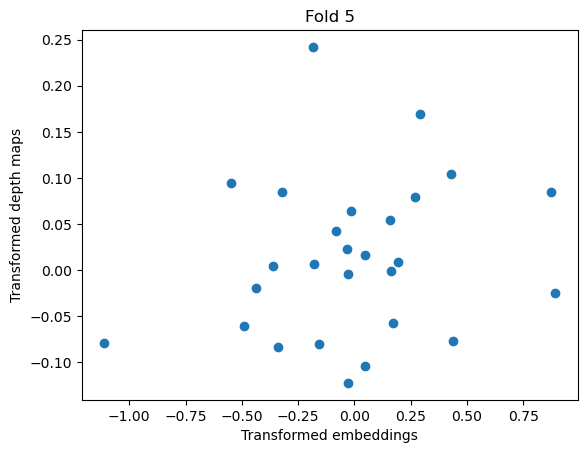

average correlation over folds is 0.18396191192987563


In [77]:
n_splits = 5  # For k-fold
kf = KFold(n_splits=n_splits)

canonical_correlations = []

for i, (train_index, test_index) in enumerate(kf.split(embeddings_frame)):
    # Split data into training and test sets
    X_train, X_test = embeddings_frame[train_index], embeddings_frame[test_index]
    Y_train, Y_test = mean_depth_map_per_frames[train_index], mean_depth_map_per_frames[test_index]

    # Initialize and fit CCA
    cca4 = CCA(n_components=1)  # Choose appropriate number of components
    cca4.fit(X_train, Y_train)

    # Transform both training and test sets
    X_train_c, Y_train_c = cca4.transform(X_train, Y_train)
    X_test_c, Y_test_c = cca4.transform(X_test, Y_test)

    # Calculate and store the canonical correlation for the test set
    test_correlation = np.corrcoef(X_test_c[:, 0], Y_test_c[:, 0])[0, 1]
    canonical_correlations.append(test_correlation)
    print(test_correlation)
    # Plot the transformed test set
    plt.figure(i)
    plt.scatter(X_test_c[:, 0], Y_test_c[:, 0])
    plt.title(f'Fold {i+1}')
    plt.xlabel('Transformed embeddings')
    plt.ylabel('Transformed depth maps')
    plt.show()

# Average canonical correlation across all folds
average_canonical_correlation = np.mean(canonical_correlations)
print(f'average correlation over folds is {average_canonical_correlation}')